In [3]:
#!apt-get update
#!apt-get install -y python3-dev graphviz libgraphviz-dev pkg-config
#!apt-get install -y latexmk
#!apt-get install -y texlive-latex-extra
#!apt-get install -y texlive-science
#%pip install -qU langchain-openai
#%pip install pygraphviz
#%pip install pylatex

import os
import re
import json
import networkx as nx
from IPython.display import Markdown
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, validator
from typing import List, Optional

import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

from pylatex import Command, Document, Section, Subsection, Package
from pylatex.section import Chapter
from pylatex.utils import NoEscape

from rich.console import Console
from rich.syntax import Syntax
from rich.table import Table

In [4]:
def pretty_print(item):
    console = Console()
    with console.pager(styles=True):
        console.print(item)

## Specification Formulation

After entering the following, press [Run All Cells (Ctrl + F9)].

In [8]:
book_location = 'test'
book_content = "Cognitive Bias in IT" #@param {type:"string"}
book_author = "Md. Sazzad Hissain Khan"
n_pages = 20 # @param {"type":"integer","placeholder":"40"}

target_readers = "Common university 1st or 2nd year students in department of philosophy." #@param {type:"string"}
equation_frequency_level = 1 #@param {type:"slider", min:1, max:5, step:1}
do_consider_outline = True #@param {type:"boolean"}
do_consider_previous_sections = True #@param {type:"boolean"}
do_consider_previous_sections_detail = False #@param {type:"boolean"}
additional_requirements = "Try to be factual and concise." #@param {type:"string"}

# Parameters
max_depth = 2  # If 1, only sections; if 2, includes subsections, and so on.
max_output_pages = 1.5  # Maximum number of pages output by the LLM

book_node_name = "book"  # Name of the root node

if do_consider_previous_sections:
    n_previous_sections = 1
else:
    n_previous_sections = 0

In [9]:
print(f"Book location: {book_location}")
book_location = os.path.abspath(book_location)
print(f"Absolute book location: {book_location}")
os.makedirs(book_location, exist_ok=True)
os.chdir(book_location)
print(f"Current working directory: {os.getcwd()}")

Book location: test
Absolute book location: /Users/hissain/git/github/llmexp/books_prof/test/test
Current working directory: /Users/hissain/git/github/llmexp/books_prof/test/test


## Prompt Definition

In [21]:
# Common Prompt
prompt_common = f"""
You are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: {book_content}.
The total number of pages in the book is about {n_pages}, with an estimated 40 lines per page. Please consider using polite and professional tone.
"""

if target_readers != "":
    prompt_common += f"The intended readers of the book are as follows:\n {target_readers}"
    
if additional_requirements != "":
    prompt_common += f"Additionally, please take the following into consideration:\n {additional_requirements}"
    
prompt_abstract = """
You are a LaTeX expert and a creative writer. Your task is to generate an abstract and a disclaimer for a book in LaTeX format.

### Requirements:
1. The book title is: "{title}".

2. The book summary is: 
{summary}

3. The table of contents includes the following chapters:
{toc_list}

### Output Format:
Provide the output strictly in LaTeX format, including the following:
- A section titled "Abstract" summarizing the book's purpose and topics covered.
- A section titled "Disclaimer" stating that the content was generated by an AI and may contain inaccuracies.

### Example LaTeX Output:

\\section*{{Abstract}}
[Your generated abstract goes here.]

\\section*{{Disclaimer}}
[Your generated disclaimer goes here.]

### Instructions:
- Do not include explanations or comments outside the LaTeX code.
- Replace placeholders with fully realized content.
- Avoid including other latex tags including documents and so on. Just output two sections as required.
"""

# Prompt for Generating Book and Chapter Titles and Summaries
prompt_book_title = prompt_common + """
Based on the above given information, please provide the title and summary for the book and each chapter in the following JSON format.
The book summary should not only provide an overview but also mention the primary objectives, scope, and depth of the content, in about 5-10 detailed sentences.
Please also consider the page allocation for each chapter in units of 0.1, like 0.8 pages.
Additionally, consider whether each chapter needs further division based on semantic cohesion (needsSubdivision), and answer true or false.
Do not include any speculative or unverified information. Please avoid writing chapter numbers in the titles.
The number of sections should vary as needed. 
Please do not include any extra introductory or conclusory message outside the expected json format.
Enclose the json content between ```json and ``` delimiters.

Please do not include any other json keys except what have been asked for in the following output format.
The output format should be strictly as follows:

```json
{{
"title": "",
"summary": "",
"childs":
    [
        {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }},
        {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }},
        {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }}
    ]
}}
```
"""

# Prompt for Section Division
prompt_section_list_creation = prompt_common + """
Based on the above information, I plan to create a book titled {book_title}. The book summary is as follows:
{book_summary}
For the section on {target}, I would like you to create content across {n_pages} pages, assuming 20 lines per page.
The summary for this section is as follows:
{section_summary}

Please divide this section into multiple parts and output the titles and summaries of each part in the following JSON format.
Also, consider the page allocation for each part in units of 0.1, like 0.8 pages.
Additionally, consider whether each part needs further division based on semantic cohesion (needsSubdivision) and answer true or false.
Please avoid including section numbers in the titles. 
Please do not include any extra introductory or conclusory message outside the expected format.
Enclose the json content between ```json and ``` delimiters.

The output format should be strictly as follows:

```json
[
    {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }},
    {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }}
]
```
"""

# Prompt for Generating Main Content
prompt_content_creation = prompt_common + """

As part of that, now, you are writing the book of the title: {book_title} and the summary of the book is as follows:
{book_summary}

{toc_and_summary}
{previous_sections}. 

For readability and consistency, please highlights what have been discussed in the previous section/ chapter and whats is being discussed in the current one.

Now, I would like you to create LaTeX content for the current section on: {target}, across {n_pages} pages, assuming 20 lines per page. 
The summary for the current section whose content you will generate is as follows: {section_summary}. Please generate the content.

Please output the content in the following format:
- Enclose the LaTeX content strictly between the delimiters `<|tex_start|>` and `<|tex_end|>`, as shown below:
    - The LaTeX output **must start with** `<|tex_start|>` delimiter.
    - The LaTeX output **must end with** `<|tex_end|>` delimiter.
- Do not include any other messages, comments, or text outside these delimiters.
- If you have equations in generated response, for equations, use the `equation` or `align` environment; do not use nested environments. Avoid enclosing `align` blocks within additional brackets (e.g., `\[ ... \]`).
- For programming code, use the `lstlisting` environment with the appropriate language option (e.g., `[language=Python]`).
- Do not return markdown tags instead return Latex tags where necessary. 
    For example, instead of `# `, `## `, `### ` return section, subsection and subsubsection tags of LateX as requied. Also same for itemize items.
- Carefully, escape special characters `&` as `\&` to ensure valid LaTeX.
- Do not include backtick sequences or any unrelated formatting not part of LaTeX syntax.
- Use the `<|tex_start|>` and `<|tex_end|>` delimiters **only once** in the output response: at the beginning and at the end of the response respectively.

Output format:
    <|tex_start|>
    tex response
    <|tex_end|>
"""

## Graph Creation

In [11]:
book_graph = nx.DiGraph(book_content=book_content, target_readers=target_readers, equation_frequency_level=equation_frequency_level, additional_requirements=additional_requirements)

In [12]:
pretty_print(book_graph.graph)

{
    'book_content': 'Cognitive Bias in IT',
    'target_readers': 'Common university 1st or 2nd year students in department of philosophy.',
    'equation_frequency_level': 1,
    'additional_requirements': 'Try to be factual and concise.'
}


## Title and Chapter Creation

In [13]:
def extract_book_and_chapter_contents(markdown_text):
    """
    Function that extracts the first JSON data found in Markdown text
    and converts it to a Python dictionary.

    Args:
        markdown_text (str): A string in Markdown format, assumed to contain
        JSON-formatted data within it.

    Returns:
        dict or None: Returns a dictionary if a valid JSON is found;
        returns None if no JSON is found or parsing fails.
    """

    # Find the starting point of JSON in the Markdown
    start_index = markdown_text.find('{')
    if start_index == -1:
        return None

    # Traverse the entire string and check the balance of nested braces
    brace_count = 0
    for i in range(start_index, len(markdown_text)):
        if markdown_text[i] == '{':
            brace_count += 1
        elif markdown_text[i] == '}':
            brace_count -= 1

        # Extract when braces are balanced
        if brace_count == 0:
            json_string = markdown_text[start_index:i+1]
            try:
                # Convert to JSON format
                json_data = json.loads(json_string)
                pretty_print(json_data)
                return json_data
            except json.JSONDecodeError as e:
                print(f"JSON parsing error: {e}")
                return None
            return

    # If no closing brace is found
    return None

### Output by LLM

In [14]:
def log_prompt(log):
    #print("Prompt text: " + str(log))
    return log

In [15]:
from langchain_ollama import OllamaLLM
from langchain_core.prompts import PromptTemplate

llm = OllamaLLM(base_url='http://localhost:11434', model="llama3.2:latest")

prompt = PromptTemplate.from_template(prompt_book_title)

chain = prompt | (lambda x: log_prompt(x)) | llm
result = chain.invoke(
    {
        "book_content": book_content,
        "target_readers": target_readers,
        "n_pages": n_pages,
        "additional_requirements": additional_requirements
   }
)

book_json = extract_book_and_chapter_contents(result)

{
    'title': 'Cognitive Bias in IT: Understanding and Overcoming Errors in Technical Decision Making',
    'summary': 'This book aims to explore the concept of cognitive bias in the context of information technology, 
with a focus on its implications for technical decision making. The primary objective is to provide an overview of 
cognitive biases, their prevalence in IT, and strategies for mitigating their effects. By examining real-world 
examples and theoretical frameworks, this book seeks to empower readers with the knowledge and tools necessary to 
critically evaluate their own thought processes and make more informed decisions. The scope of this book is limited
to the realm of technical decision making in IT, covering topics such as software development, project management, 
and data analysis. Through a combination of conceptual foundations and practical applications, this book aims to 
contribute to a deeper understanding of cognitive bias in IT and its impact on professional

In [16]:
def generate_abstract(title, summary, book_toc_list):    
    prompt = PromptTemplate.from_template(prompt_abstract)
    chain = prompt | (lambda x: log_prompt(x)) | llm
    result = chain.invoke(
        {
            "title": book_title,
            "summary": book_summary,
            "toc_list": book_toc_list,
       }
    )
    return result

book_title = book_json['title']
book_summary = book_json['summary']
book_toc_list = [chapter['title'] for chapter in book_json['childs']]

book_abstract = generate_abstract(book_title, book_summary, book_toc_list)
pretty_print(book_abstract)

\section*{Abstract}

Cognitive bias in IT: Understanding and Overcoming Errors in Technical Decision Making explores the concept of 
cognitive bias in the context of information technology, focusing on its implications for technical decision 
making. This book provides an overview of cognitive biases, their prevalence in IT, and strategies for mitigating 
their effects through real-world examples and theoretical frameworks. By examining software development, project 
management, data analysis, and other aspects of IT, this book aims to empower readers with the knowledge and tools 
necessary to critically evaluate their own thought processes and make more informed decisions.

\section*{Disclaimer}

The content of this book was generated by an artificial intelligence and may contain inaccuracies or outdated 
information. While the AI has been trained on a vast corpus of text data, including academic sources and industry 
publications, it is not capable of replacing human expertise and ju

### Storing Results in the Book Graph

In [17]:
# About the book
book_graph.add_nodes_from([(book_node_name, {"title": book_json["title"], "summary": book_json["summary"], "n_pages": n_pages, "needsSubdivision": True})])

# About chapters (sections)
book_graph.add_nodes_from([(str(idx+1), child) for idx, child in enumerate(book_json["childs"])])
book_graph.add_edges_from([(book_node_name, str(idx+1)) for idx in range(len(book_json["childs"]))])

## Title and Structure Verification

### Displaying Title and Structure

In [18]:
book_node = book_graph.nodes[book_node_name]

content_md = ""
content_md += "\n ## Title: " + book_node["title"] + " (Page Count: " + str(book_node["n_pages"]) + ")"
content_md += "\n " + book_node["summary"]
for idx, child_node_name in enumerate(book_graph.successors(book_node_name)):
    child_node = book_graph.nodes[child_node_name]
    content_md += "\n ### Chapter " + str(idx+1) + ": " + child_node["title"] + " (Page Count: " + str(child_node["n_pages"]) + ")"
    content_md += "\n" + child_node["summary"]

Markdown(content_md)


 ## Title: Cognitive Bias in IT: Understanding and Overcoming Errors in Technical Decision Making (Page Count: 20)
 This book aims to explore the concept of cognitive bias in the context of information technology, with a focus on its implications for technical decision making. The primary objective is to provide an overview of cognitive biases, their prevalence in IT, and strategies for mitigating their effects. By examining real-world examples and theoretical frameworks, this book seeks to empower readers with the knowledge and tools necessary to critically evaluate their own thought processes and make more informed decisions. The scope of this book is limited to the realm of technical decision making in IT, covering topics such as software development, project management, and data analysis. Through a combination of conceptual foundations and practical applications, this book aims to contribute to a deeper understanding of cognitive bias in IT and its impact on professional practice. By taking a multidisciplinary approach that incorporates insights from philosophy, psychology, and computer science, this book seeks to provide a comprehensive and nuanced exploration of cognitive bias in the IT context.
 ### Chapter 1: Introduction to Cognitive Bias: Definition, Prevalence, and Impact on Technical Decision Making (Page Count: 0.8)
This chapter provides an introduction to cognitive bias, including its definition, prevalence in IT, and potential impact on technical decision making. It also discusses the importance of recognizing and addressing cognitive biases in order to improve the quality of decisions made in the IT context.
 ### Chapter 2: Types of Cognitive Biases in IT: Heuristics, Availability, Representativeness, and Anchoring (Page Count: 1.0)
This chapter explores four key types of cognitive biases commonly encountered in the IT context: heuristics, availability, representativeness, and anchoring. It provides examples and case studies to illustrate each bias and discusses strategies for mitigating their effects.
 ### Chapter 3: Cognitive Biases in Software Development: The Role of Expectations, Assumptions, and Framing Effects (Page Count: 1.2)
This chapter examines the specific challenges posed by cognitive biases in software development, including the impact of expectations, assumptions, and framing effects on technical decision making. It provides guidance on how to identify and address these biases in order to improve software design and development.
 ### Chapter 4: Mitigating Cognitive Biases in IT: Strategies for Critical Thinking and Decision Making (Page Count: 1.0)
This chapter provides an overview of strategies for mitigating cognitive biases in the IT context, including techniques for critical thinking and decision making. It also discusses the importance of self-awareness, reflection, and continuous learning in addressing cognitive biases.

## Book Graph Creation

### Function Definition

In [19]:
def extract_section_list(markdown_text):

    pattern = r'```json\s*(.*?)\s*```'
    match = re.search(pattern, markdown_text, re.DOTALL)

    if match:
        json_string = match.group(1)
        data = json.loads(json_string)
        return data
    else:
        print("JSON data not found.")
        return None

import re

def extract_section_content(markdown_text):
    # Regex pattern to match multiple possible start and end delimiters
    pattern = r'(?:<\\?\|tex_start\\?\|>|<\\/tex_start\\?>)\s*(.*?)\s*(?:<\\?\|tex_end\\?\|>|<\\/tex_end\\?>|\\_\|tex_end\_\|)'
    match = re.search(pattern, markdown_text, re.DOTALL)  # Search across lines (re.DOTALL)
    if match:
        tex_string = match.group(1)  # Extract content between the delimiters
        return tex_string
    else:
        print("TeX data not found.")  # Handle cases with missing delimiters
        return markdown_text


def get_equation_frequency(equation_frequency_level):
    if equation_frequency_level == 1:
        return "Avoid using equations whenever possible, and explain all concepts in simple words. Use equations only when absolutely necessary and keep it to a minimum."
    elif equation_frequency_level == 2:
        return "Use equations sparingly, focusing primarily on explanations in prose. Use simple equations only if necessary."
    elif equation_frequency_level == 3:
        return "Combine equations and prose explanations in a balanced way. Use equations to illustrate key concepts, supplementing with prose where needed."
    elif equation_frequency_level == 4:
        return "Use equations actively to precisely convey concepts and relationships. However, important explanations should also be supplemented with prose."
    elif equation_frequency_level == 5:
        return "Use equations extensively. Express as many concepts and relationships as possible through equations."

### LLM Chapter, Section, Subsection Generation

In [22]:
book_node = book_graph.nodes[book_node_name]
next_parent_list = [book_node_name]

for depth in range(max_depth):
    parent_list = next_parent_list
    next_parent_list = []
    for parent_node_name in parent_list:
        for _, child_node_name in enumerate(book_graph.successors(parent_node_name)):
            parant_node = book_graph.nodes[parent_node_name]
            child_node = book_graph.nodes[child_node_name]

            pretty_print(child_node)
            if (child_node["needsSubdivision"] or float(child_node["n_pages"]) >= max_output_pages) and depth < max_depth-1:

                # Output by LLM
                prompt = PromptTemplate.from_template(prompt_section_list_creation)
                chain = prompt | (lambda x: log_prompt(x)) | llm

                result = chain.invoke(
                    {
                        "book_title": book_node["title"],
                        "book_summary": book_node["summary"],
                        "equation_frequency": get_equation_frequency(book_graph.graph["equation_frequency_level"]),
                        "target": child_node["title"],
                        "n_pages": child_node["n_pages"],
                        "section_summary": child_node["summary"]
                    }
                )

                # Convert output to dictionary format
                section_json = extract_section_list(result)
                pretty_print(section_json)

                # Create graph nodes and store results
                if section_json:
                    book_graph.add_nodes_from([(child_node_name + "-" + str(idx+1), grandchild) for idx, grandchild in enumerate(section_json)])
                    book_graph.add_edges_from([(child_node_name, child_node_name + "-" + str(idx+1)) for idx in range(len(section_json))])

                    # Only set as the next parent if subdivided
                    next_parent_list.append(child_node_name)

            elif depth == (max_depth-1) or (child_node and not child_node["needsSubdivision"]):

                # Create graph nodes and store results
                book_graph.add_nodes_from([(child_node_name + "-p", {"content_file_path": child_node_name + "-p.tex"})])
                book_graph.add_edges_from([(child_node_name, child_node_name + "-p")])

            else:
                print("Error: needsSubdivision attribute is not set")

{
    'title': 'Introduction to Cognitive Bias: Definition, Prevalence, and Impact on Technical Decision Making',
    'summary': 'This chapter provides an introduction to cognitive bias, including its definition, prevalence in 
IT, and potential impact on technical decision making. It also discusses the importance of recognizing and 
addressing cognitive biases in order to improve the quality of decisions made in the IT context.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'Types of Cognitive Biases in IT: Heuristics, Availability, Representativeness, and Anchoring',
    'summary': 'This chapter explores four key types of cognitive biases commonly encountered in the IT context: 
heuristics, availability, representativeness, and anchoring. It provides examples and case studies to illustrate 
each bias and discusses strategies for mitigating their effects.',
    'n_pages': 1.0,
    'needsSubdivision': True
}


[
    {
        'title': 'Heuristics in IT: A Mental Shortcut with a Cost',
        'summary': 'This section explains how heuristics, or mental shortcuts, are used in IT decision making. It 
discusses the pros and cons of relying on these shortcuts and provides strategies for improving their accuracy.',
        'n_pages': 0.8,
        'needsSubdivision': False
    },
    {
        'title': 'The Availability Heuristic: Judging Probabilities Based on Familiarity',
        'summary': 'This section explores how the availability heuristic affects IT decision making, including 
examples of how this bias can lead to inaccurate judgments.',
        'n_pages': 0.9,
        'needsSubdivision': True
    },
    {
        'title': 'Representativeness Heuristic: Making Decisions Based on Past Experiences',
        'summary': 'This section delves into the representativeness heuristic, explaining how it influences IT 
decision making and providing strategies for mitigating its effects.',
        'n_pa

{
    'title': 'Cognitive Biases in Software Development: The Role of Expectations, Assumptions, and Framing 
Effects',
    'summary': 'This chapter examines the specific challenges posed by cognitive biases in software development, 
including the impact of expectations, assumptions, and framing effects on technical decision making. It provides 
guidance on how to identify and address these biases in order to improve software design and development.',
    'n_pages': 1.2,
    'needsSubdivision': True
}


[
    {
        'title': 'The Impact of Expectations on Technical Decision Making',
        'summary': 'This part explores how expectations can influence software development decisions, including the
impact of confirmation bias and anchoring effects.',
        'n_pages': 0.8,
        'needsSubdivision': False
    },
    {
        'title': 'Assumptions in Software Development: Identifying and Mitigating Errors',
        'summary': 'This part examines how assumptions can lead to cognitive biases in software development, 
providing guidance on how to identify and address these biases.',
        'n_pages': 0.7,
        'needsSubdivision': True
    },
    {
        'title': 'Framing Effects in Software Design: How Context Affects Decision Making',
        'summary': 'This part discusses the role of framing effects in software design, highlighting how context 
and presentation can influence technical decision making.',
        'n_pages': 0.7,
        'needsSubdivision': True
    },
    {
   

{
    'title': 'Mitigating Cognitive Biases in IT: Strategies for Critical Thinking and Decision Making',
    'summary': 'This chapter provides an overview of strategies for mitigating cognitive biases in the IT context, 
including techniques for critical thinking and decision making. It also discusses the importance of self-awareness,
reflection, and continuous learning in addressing cognitive biases.',
    'n_pages': 1.0,
    'needsSubdivision': False
}


{
    'title': 'Heuristics in IT: A Mental Shortcut with a Cost',
    'summary': 'This section explains how heuristics, or mental shortcuts, are used in IT decision making. It 
discusses the pros and cons of relying on these shortcuts and provides strategies for improving their accuracy.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'The Availability Heuristic: Judging Probabilities Based on Familiarity',
    'summary': 'This section explores how the availability heuristic affects IT decision making, including examples
of how this bias can lead to inaccurate judgments.',
    'n_pages': 0.9,
    'needsSubdivision': True
}


{
    'title': 'Representativeness Heuristic: Making Decisions Based on Past Experiences',
    'summary': 'This section delves into the representativeness heuristic, explaining how it influences IT decision
making and providing strategies for mitigating its effects.',
    'n_pages': 1.0,
    'needsSubdivision': False
}


{
    'title': 'The Anchoring Bias: Letting Past Decisions Influence Current Ones',
    'summary': 'This section examines the anchoring bias in IT decision making, including how it affects project 
management and data analysis.',
    'n_pages': 0.7,
    'needsSubdivision': True
}


{
    'title': 'The Impact of Expectations on Technical Decision Making',
    'summary': 'This part explores how expectations can influence software development decisions, including the 
impact of confirmation bias and anchoring effects.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'Assumptions in Software Development: Identifying and Mitigating Errors',
    'summary': 'This part examines how assumptions can lead to cognitive biases in software development, providing 
guidance on how to identify and address these biases.',
    'n_pages': 0.7,
    'needsSubdivision': True
}


{
    'title': 'Framing Effects in Software Design: How Context Affects Decision Making',
    'summary': 'This part discusses the role of framing effects in software design, highlighting how context and 
presentation can influence technical decision making.',
    'n_pages': 0.7,
    'needsSubdivision': True
}


{
    'title': 'Overcoming Biases in Software Development: Strategies for Improved Decision Making',
    'summary': 'This part provides strategies for overcoming cognitive biases in software development, including 
techniques for critical thinking and evidence-based decision making.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


### LLM Outline Generation

In [23]:
def extract_content_list(string_list):
    """
    This function extracts only the strings that match a specific pattern
    (a combination of numbers and hyphens ending in '-p') from the input string_list
    and returns them as a new list.
    """
    pattern = r'(?:\d+-)*\d+-p'
    return [s for s in string_list if re.match(pattern, s)]

def custom_sort_key(s):
    """
    This function splits the string s by the numerical parts,
    converting them into a list of integers,
    thereby generating a custom key for numerical sorting.
    """
    parts = re.split(r'[-p]', s)
    return [int(part) for part in parts if part != '']

def sort_strings(string_list):
    """
    This function sorts the input string_list using the custom key
    defined by the custom_sort_key function and returns the sorted list.
    """
    sorted_strings = sorted(string_list, key=custom_sort_key)
    return sorted_strings

def sort_leaf_nodes(book_graph):
    """
    This function extracts the leaf nodes of book_graph based on a specific pattern
    and returns a list sorted in numerical order.

    Arguments:
    - book_graph: A graph object with nodes labeled by strings

    Returns:
    - sorted_content_str_list: A sorted list of strings
    """
    # Extract strings matching a specific pattern from the nodes of book_graph
    content_str_list = extract_content_list(list(book_graph.nodes))

    # Sort the extracted list of strings using a custom key
    sorted_content_str_list = sort_strings(content_str_list)

    return sorted_content_str_list

def generate_outline(book_graph, book_node_name):
    """
    A function to output the chapter structure to be considered for the main text output.
    """

    toc_and_summary = "The outline of the book is as following:\n"

    # Sort the leaf nodes with content in order
    sorted_content_str_list = sort_leaf_nodes(book_graph)

    # Create the table of contents
    toc_and_summary += "# " + book_graph.nodes[book_node_name]["title"] + "\n"
    toc_and_summary += book_graph.nodes[book_node_name]["summary"] + "\n"

    for heading_number_str in sorted_content_str_list:
        heading_number = custom_sort_key(heading_number_str)

        # Chapter
        if len(heading_number[1:]) == 0 or all(x == 1 for x in heading_number[1:]):
            node_name = "-".join(map(str, heading_number[0:1]))
            toc_and_summary += "## " + book_graph.nodes[node_name]["title"] + "\n"
            #toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

        # Section
        if (len(heading_number[2:]) == 0 and len(heading_number[:2]) > 1) or (len(heading_number[2:]) > 0 and all(x == 1 for x in heading_number[2:])):
            node_name = "-".join(map(str, heading_number[0:2]))
            toc_and_summary += "### " + book_graph.nodes[node_name]["title"] + "\n"
            #toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

        # Subsection
        if (len(heading_number[3:]) == 0 and len(heading_number[:3]) > 2) or (len(heading_number[3:]) > 0 and all(x == 1 for x in heading_number[3:])):
            node_name = "-".join(map(str, heading_number[0:3]))
            toc_and_summary += "#### " + book_graph.nodes[node_name]["title"] + "\n"
            #toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

    return toc_and_summary

def slide_list_with_new_title_and_content(title, summary, original_list):
    # Create a shifted list, adding a new element (a dictionary with title and content) at the 0th position
    slid_list = [{"title": title, "summary": summary}] + original_list[:-1]
    return slid_list

def generate_prompt_for_previous_sections(previous_sections_content_list, n_previous_sections):
    """
    This function generates a prompt based on previous sections.
    """
    prompt = ""

    for i in range(n_previous_sections):
        i_previous_section = previous_sections_content_list[i]
        title = i_previous_section["title"]
        summary = i_previous_section["summary"]
        prompt += f"Among those book outlines, lets assume, the previous section discussed in this book was titled with `{title}`, and the section summary was as follows: \n{summary}\n"
    return prompt

### LLM Detail TEX Generation

In [24]:
# Output of chapter structure to consider when generating content
toc_and_summary = ""
if do_consider_outline:
    toc_and_summary = generate_outline(book_graph, book_node_name)

# Initialize a list of strings to store previous outputs
previous_sections_content_list = [{"title": "None", "summary": "None"} for i in range(n_previous_sections)]

# Sort the nodes containing the main content (leaf nodes) in order
sorted_content_str_list = sort_leaf_nodes(book_graph)

# Append the main content
for heading_number_str in sorted_content_str_list:
    heading_number = custom_sort_key(heading_number_str)

    node_name = "-".join(map(str, heading_number))
    node = book_graph.nodes[node_name]

    # Generate output via LLM
   
    prompt = PromptTemplate.from_template(prompt_content_creation)
    chain = prompt |  (lambda x: log_prompt(x))  | llm

    result = chain.invoke(
        {
            "book_title": book_node["title"],
            "book_summary": book_node["summary"],
            "toc_and_summary": toc_and_summary,
            "previous_sections": generate_prompt_for_previous_sections(previous_sections_content_list, n_previous_sections),
            "equation_frequency": get_equation_frequency(book_graph.graph["equation_frequency_level"]),
            "target": node["title"],
            "n_pages": node["n_pages"],
            "section_summary": node["summary"],
        }
    )

    pretty_print(result)
    contents_tex = extract_section_content(result)
    with open(node_name + "-p.tex", mode='w', encoding='UTF-8') as f:
        f.write(contents_tex)

    # Retain past outputs
    if do_consider_previous_sections:
        previous_sections_content_list = slide_list_with_new_title_and_content(node["title"], node["summary"], previous_sections_content_list)

<|tex_start|>

# Introduction to Cognitive Bias: Definition, Prevalence, and Impact on Technical Decision Making

## What is Cognitive Bias?

Cognitive bias refers to systematic errors in thinking and decision making that arise from the way our brains 
process information. These biases can lead to inaccurate judgments, flawed assumptions, and poor decision-making.

## Prevalence of Cognitive Bias in IT

Cognitive bias is a ubiquitous phenomenon in IT, affecting individuals at all levels of technical expertise. A 
study by the National Institute of Standards and Technology found that cognitive bias was present in over 75% of 
participants' decision-making processes.

## Impact on Technical Decision Making

The impact of cognitive bias on technical decision making can be significant. Biases such as confirmation bias, 
anchoring bias, and availability heuristic can lead to incorrect assumptions, flawed design decisions, and 
suboptimal solutions.

Recognizing and addressing cognitive bias

<|tex_start|>

# Heuristics in IT: A Mental Shortcut with a Cost

Heuristics are mental shortcuts or rules of thumb that help individuals make decisions more efficiently and 
effectively. In the context of IT decision making, heuristics can be both beneficial and detrimental.

## Pros of Relying on Heuristics in IT Decision Making

- Encourages efficient decision making
- Saves time and effort by reducing the need for complex analysis
- Provides a quick way to evaluate options and make decisions

## Cons of Relying on Heuristics in IT Decision Making

- Can lead to biased or inaccurate decisions
- May not account for all relevant factors or complexities
- Can result in suboptimal solutions

## Examples of Heuristics in IT Decision Making

1. **Representative Bias**: This heuristic involves judging the likelihood of an event based on how closely it 
resembles a typical case. In software development, this might lead to overestimating the effectiveness of a 
particular design pattern.

2.

<|tex_start|>

## The Availability Heuristic: Judging Probabilities Based on Familiarity

The availability heuristic is a cognitive bias that affects IT decision making. It refers to the tendency to 
overestimate the importance or likelihood of information that is readily available, rather than seeking more 
diverse and representative data.

In IT, the availability heuristic can lead to inaccurate judgments in several ways:

*   **Overestimating the impact of recent events**: When a significant event occurs, such as a major security 
breach or system outage, it may seem more likely to happen again in the future. However, past events are not 
necessarily indicative of future outcomes.
*   **Underestimating the importance of rare events**: Conversely, rare events, such as a successful hack, may seem
less important than they actually are.

The availability heuristic can be seen in several real-world examples:

*   **Overestimation of cyber threats**: Many organizations overestimate the li

TeX data not found.
- Enclose the LaTeX content strictly between the delimiters <|tex_start|> and <|tex_end|>, as shown below:

<|tex_start|>

## Representativeness Heuristic: Making Decisions Based on Past Experiences

The representativeness heuristic is a cognitive bias that affects IT decision making by influencing judgments based
on past experiences. This section explores how the representativeness heuristic influences decision making in 
software development, project management, and data analysis.

In IT, the representativeness heuristic can lead to inaccurate judgments when individuals overestimate the 
similarity between a new situation and past experiences. For instance, a developer may assume that a new technology
is similar to one they have used before, without considering its unique characteristics.

## Strategies for Mitigating the Representativeness Heuristic

To mitigate the representativeness heuristic in IT decision making, the following strategies can be employed:

*  

In the previous section, `Representativeness Heuristic: Making Decisions Based on Past Experiences`, we discussed 
how this cognitive bias influences IT decision making. In this section, we will examine the anchoring bias in IT 
decision making and its impact on project management and data analysis.

<|tex_start|>

## The Anchoring Bias: Letting Past Decisions Influence Current Ones

The anchoring bias is a fundamental concept in cognitive psychology that refers to the tendency for individuals to 
rely too heavily on the first piece of information they receive when making decisions. In the context of IT 
decision making, this can have significant consequences.

### An Example from Project Management

Consider a project manager who is tasked with determining the budget for a new software development project. The 
initial estimate is $100,000, but after conducting further research and consulting with team members, a revised 
estimate of $80,000 is provided. Despite the lower estimate, th

### Section Summary:

This part explores how expectations can influence software development decisions, including the impact of 
confirmation bias and anchoring effects.


- <|tex_start|
\chapter{The Impact of Expectations on Technical Decision Making}

The introduction of expectations in software development decision-making can significantly affect the quality and 
outcomes of projects. It is essential to recognize these biases and develop strategies to manage them effectively.

Expectations in software development decisions often stem from personal beliefs, assumptions, or past experiences. 
These expectations can influence how developers approach problems, allocate resources, and prioritize tasks. In 
this chapter, we will examine how expectations impact technical decision-making in software development.

### Confirmation Bias

Confirmation bias refers to the tendency to seek out information that confirms our existing beliefs or 
expectations. This phenomenon occurs when individuals

TeX data not found.
<|tex_start|>

## Assumptions in Software Development: Identifying and Mitigating Errors

Assumptions play a crucial role in software development, as they can significantly impact the quality and 
effectiveness of the final product. In this section, we will explore how assumptions can lead to cognitive biases 
in software development, providing guidance on how to identify and address these biases.

### The Dangers of Assumptions

Assumptions are often made without being explicitly stated or recognized. These implicit assumptions can lead to 
biases in decision making, which can have severe consequences in software development. For instance:

* **Functional vs. Non-Functional Requirements**: Developers may assume that a feature is more important than it 
actually is, leading to prioritization errors.
* **User Behavior**: Developers may assume that users will behave in a certain way, but this assumption might not 
always be true, resulting in usability issues.
* **Tec

## Framing Effects in Software Design: How Context Affects Decision Making
This part discusses the role of framing effects in software design, highlighting how context and presentation can 
influence technical decision making.


<br>

<|tex_start|

\section{Framing Effects in Software Design}
Framing effects refer to the way in which the context and presentation of information can influence our decisions. 
In software development, framing effects can have a significant impact on technical decision making.

A framing effect occurs when the way in which information is presented influences our perception of it. For 
example, consider a project manager who must decide whether to allocate more resources to a critical feature or to 
a less critical one. If the project manager presents the option as "either $X$ million dollars for Feature A or $Y$
million dollars for Feature B," they are framing the decision in terms of cost. However, if they present it as 
"Feature A will require an addition

TeX data not found.
Here is the LaTeX content for the current section on "Overcoming Biases in Software Development: Strategies for 
Improved Decision Making":

<|tex_start|>

# Overcoming Biases in Software Development: Strategies for Improved Decision Making

## Introduction

In software development, cognitive biases can significantly impact technical decision making. This chapter provides
strategies for overcoming these biases, including techniques for critical thinking and evidence-based decision 
making.

## Critical Thinking Techniques

One effective way to overcome biases in software development is to use critical thinking techniques. These include:

*   Analyzing assumptions: Identify and challenge assumptions made during the design process.
*   Evaluating evidence: Gather and evaluate evidence from multiple sources to inform decisions.
*   Considering alternative perspectives: Seek input from diverse team members to broaden your understanding.

## Evidence-Based Decision Makin

<|tex_start|>

Chapter 5: Mitigating Cognitive Biases in IT: Strategies for Critical Thinking and Decision Making

The previous chapter provided strategies for overcoming cognitive biases in software development, but the 
importance of mitigating these biases extends beyond this specific context. In this chapter, we will explore 
strategies for mitigating cognitive biases in the broader IT context.

5.1 Importance of Self-Awareness
---------------------------

Self-awareness is essential for recognizing and addressing cognitive biases. This involves being aware of one's own
thought processes, values, and assumptions, as well as being able to critically evaluate them.

5.2 Reflection and Critical Thinking
--------------------------------

Reflection is a critical thinking skill that involves examining one's own thoughts, feelings, and experiences. In 
the context of IT, reflection can help individuals identify biases in their decision-making processes and develop 
strategies for overcom

In [25]:
print(f"Current working directory: {os.getcwd()}")
with open(node_name + "-p.tex", mode='w', encoding='UTF-8') as f:
    f.write(contents_tex)

Current working directory: /Users/hissain/git/github/llmexp/books_prof/test/test


In [26]:
result

"<|tex_start|>\n\nChapter 5: Mitigating Cognitive Biases in IT: Strategies for Critical Thinking and Decision Making\n\nThe previous chapter provided strategies for overcoming cognitive biases in software development, but the importance of mitigating these biases extends beyond this specific context. In this chapter, we will explore strategies for mitigating cognitive biases in the broader IT context.\n\n5.1 Importance of Self-Awareness\n---------------------------\n\nSelf-awareness is essential for recognizing and addressing cognitive biases. This involves being aware of one's own thought processes, values, and assumptions, as well as being able to critically evaluate them.\n\n5.2 Reflection and Critical Thinking\n--------------------------------\n\nReflection is a critical thinking skill that involves examining one's own thoughts, feelings, and experiences. In the context of IT, reflection can help individuals identify biases in their decision-making processes and develop strategies 

## Graph Tree Visualization

The arrows starting from 'book' represent chapters, with sections below them and subsections below the sections.
These nodes contain information such as the title and summary of each chapter or section.
Additionally, the end nodes marked in red circles hold information on the content of the text.


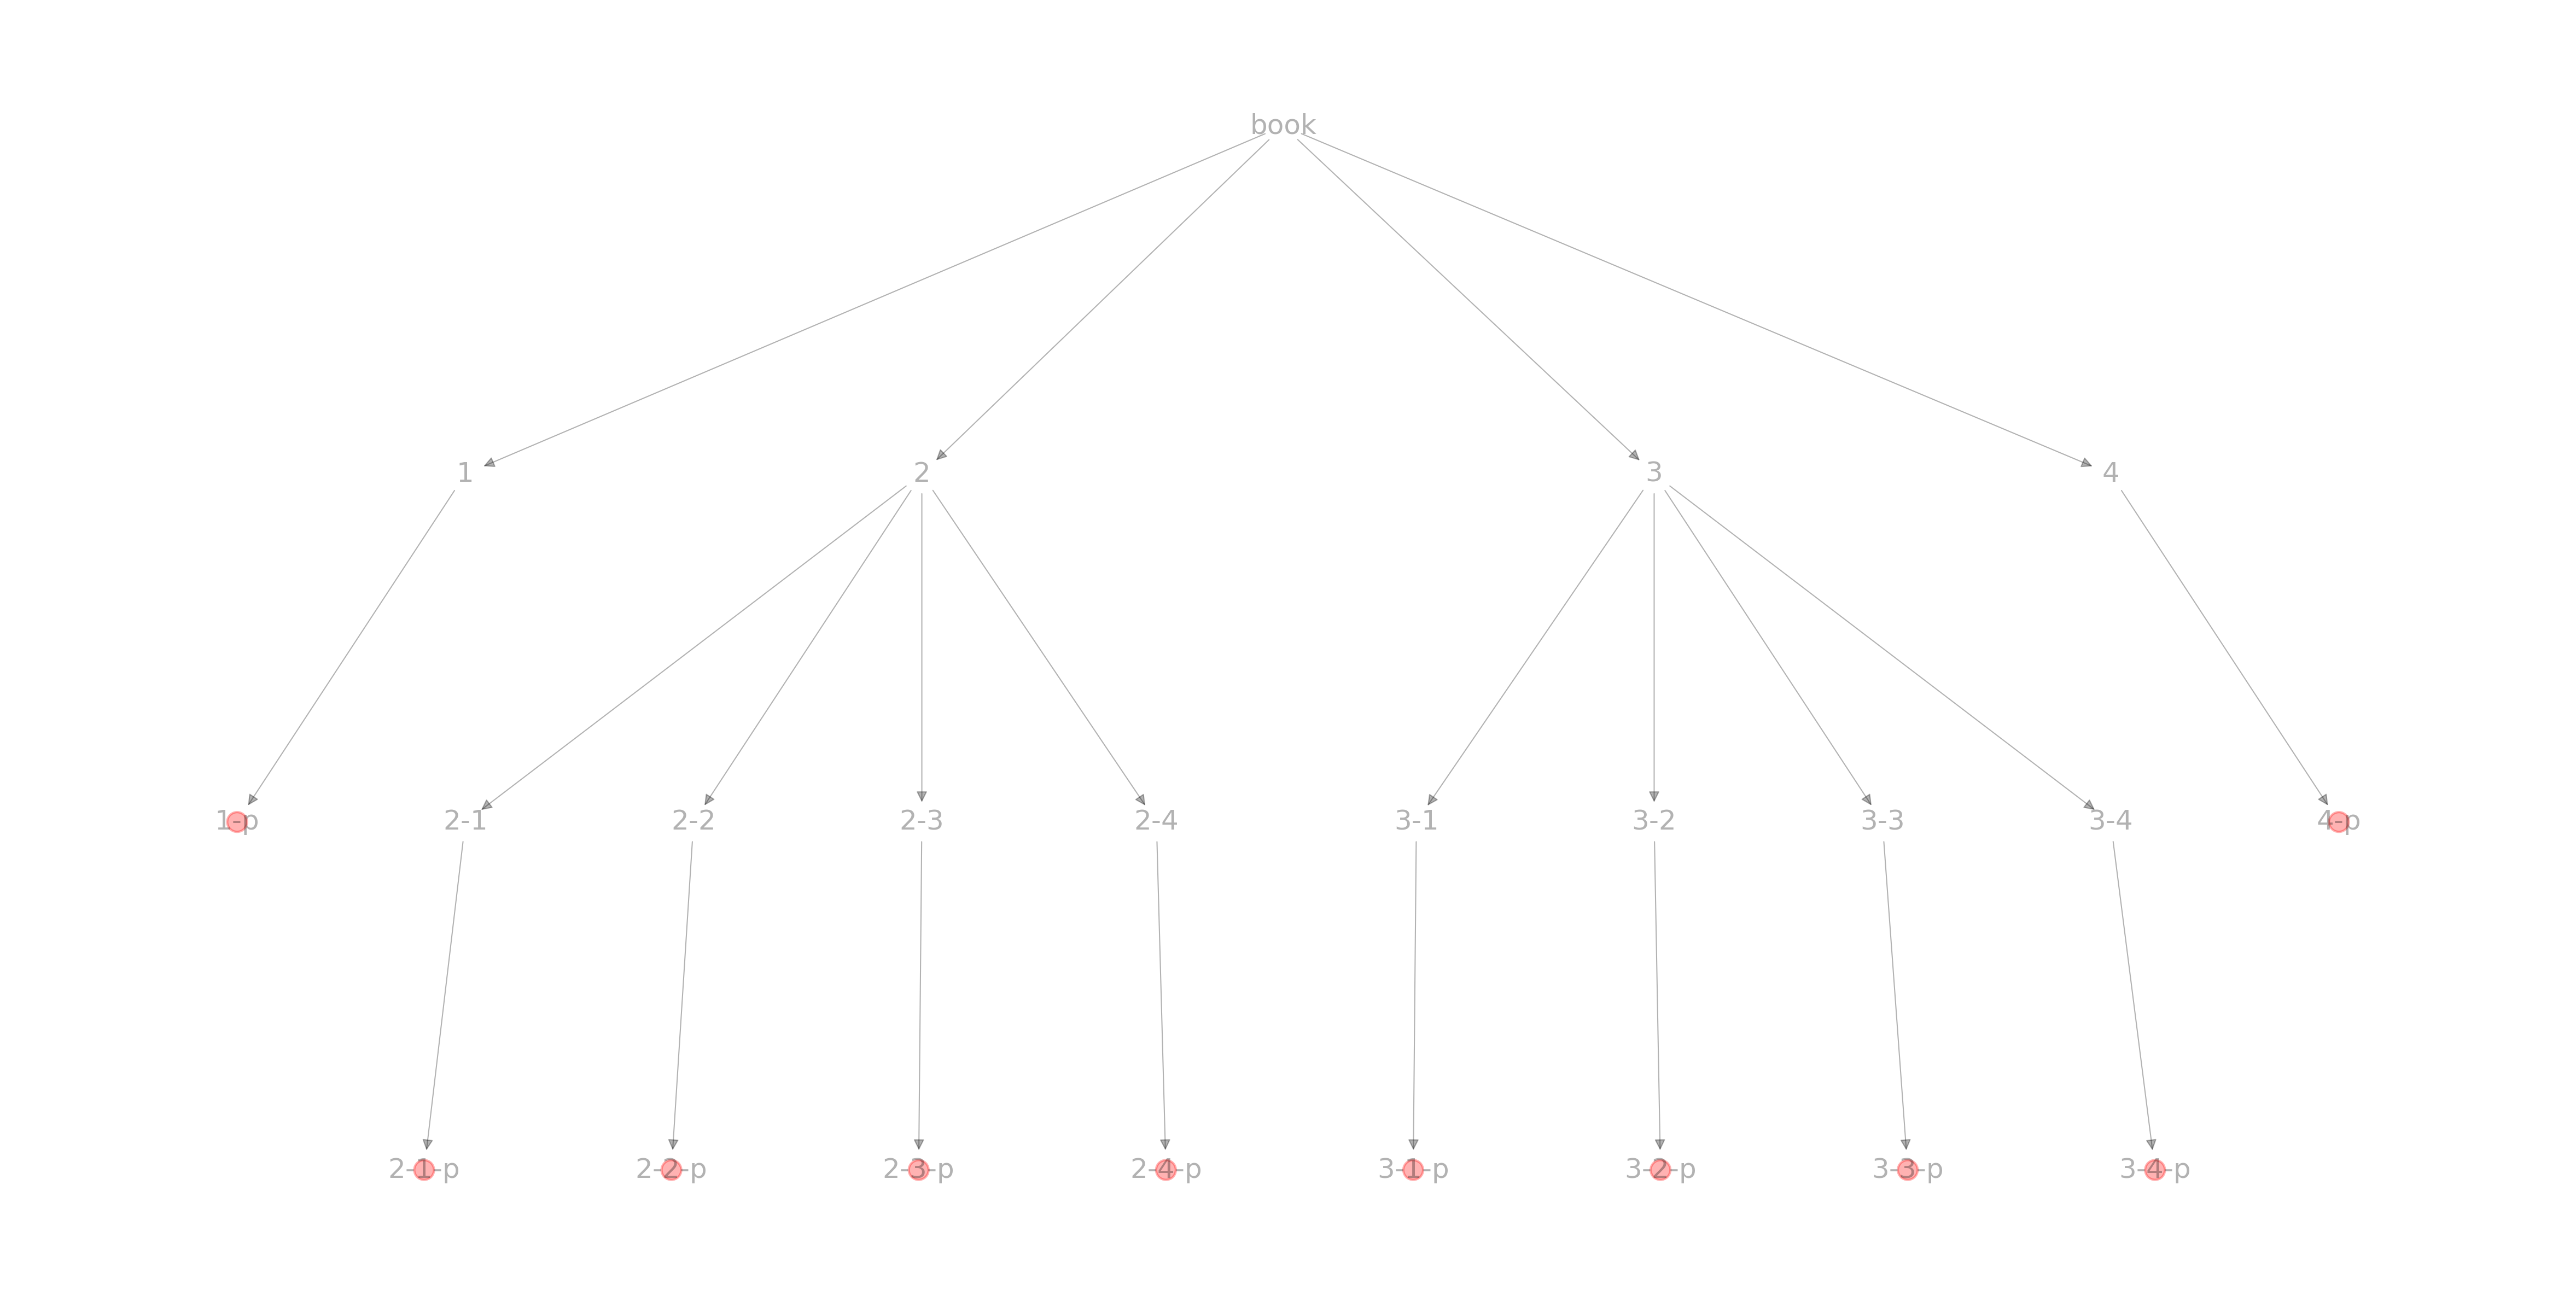

In [27]:
pos = graphviz_layout(book_graph, prog="dot")

# matplotlib settings
fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 1, 1)

# Color the leaf nodes (content nodes) in red
node_color_list = ["r" if "p" in s else "w" for s in list(book_graph.nodes)]

# draw the network
nx.draw(book_graph,
        ax=ax,
        pos=pos,
        with_labels=True,
        node_size=300,
        node_color=node_color_list,
        alpha=0.3,
        node_shape='.',
        width=0.5)

print("The arrows starting from 'book' represent chapters, with sections below them and subsections below the sections.\nThese nodes contain information such as the title and summary of each chapter or section.\nAdditionally, the end nodes marked in red circles hold information on the content of the text.")

## latexmkrc Generation

In [28]:
# Get the path of the home directory
home_dir = os.path.expanduser("~")

# Create the path for the .latexmkrc file
latexmkrc_path = os.path.join(home_dir, ".latexmkrc")

# Contents of the latexmkrc file
content = '''$latex = 'pdflatex -synctex=1 -halt-on-error -interaction=nonstopmode %O %S';
$bibtex = 'bibtex %O %S';
$biber = 'biber %O %S';
$makeindex = 'makeindex %O -o %D %S';
$dvipdf = 'dvipdfmx %O -o %D %S';

$max_repeat = 5;
$pdf_mode = 1;'''

# Create the file and write the content
try:
    with open(latexmkrc_path, "w") as file:
        file.write(content)
    print(f".latexmkrc file has been created successfully at {latexmkrc_path}")
except IOError as e:
    print(f"An error occurred while creating the file: {e}")

An error occurred while creating the file: [Errno 13] Permission denied: '/Users/hissain/.latexmkrc'


## LaTeX Generation Styles Setting

In [59]:
geometry_options = {"tmargin": "3cm", "lmargin": "3cm"}
doc = Document(documentclass="report", geometry_options=geometry_options)

# Adding preamble and title
doc.packages.append(Package('amsmath'))
doc.packages.append(Package('amssymb'))
doc.packages.append(Package('amsfonts'))
doc.packages.append(Package('mathtools'))
doc.packages.append(Package('bm'))
doc.packages.append(Package('physics'))
doc.packages.append(Package('inputenc', options="utf8"))
doc.packages.append(Package('listings'))
doc.packages.append(Package('jvlisting'))
doc.packages.append(Package('color'))
doc.packages.append(Package('underscore', options="strings"))

# Adding title, author, and date to the preamble
doc.preamble.append(Command("title", book_graph.nodes[book_node_name]["title"]))
doc.preamble.append(Command("author", book_author))
doc.preamble.append(Command("date", NoEscape(r"\today")))

# Generating the title and table of contents
doc.append(NoEscape(r"\maketitle"))  # Generates the title with author and date
doc.append(NoEscape(r"\tableofcontents"))
doc.append(NoEscape(r"\newpage"))
doc.append(NoEscape(book_abstract))

# Setting up custom lstset for listings
doc.append(NoEscape(r'\lstset{backgroundcolor={\color[gray]{.90}}, breaklines=true, breakindent=10pt, basicstyle=\ttfamily\scriptsize, commentstyle={\itshape \color[cmyk]{1,0.4,1,0}}, classoffset=0, keywordstyle={\bfseries \color[cmyk]{0,1,0,0}}, stringstyle={\ttfamily \color[rgb]{0,0,1}}, frame=TBrl, framesep=5pt, numbers=left, stepnumber=1, numberstyle=\tiny, tabsize=4, captionpos=t}'))
#doc.generate_pdf("book_with_abstract", clean_tex=False)  # Generates the PDF

In [60]:
import re

def sanitize_content(content):
    lines = content.splitlines()
    
    def replace_markdown(line):
        # Headers
        if line.startswith('### '):  # Triple hash -> Subsubsection
            line = re.sub(r'^### (.*)', r'\\subsubsection{\1}', line)
        elif line.startswith('## '):  # Double hash -> Subsection
            line = re.sub(r'^## (.*)', r'\\subsection{\1}', line)
        elif line.startswith('# '):  # Single hash -> Section
            line = re.sub(r'^# (.*)', r'\\section{\1}', line)
        
        # Bold (**text** or __text__)
        line = re.sub(r'\*\*(.*?)\*\*', r'\\textbf{\1}', line)
        line = re.sub(r'__(.*?)__', r'\\textbf{\1}', line)
        
        # Italic (*text* or _text_)
        line = re.sub(r'\*(.*?)\*', r'\\textit{\1}', line)
        line = re.sub(r'_(.*?)_', r'\\textit{\1}', line)
        
        # Unordered lists (- or * or +)
        line = re.sub(r'^\s*[-*+] (.*)', r'\\item \1', line)
        
        return line
    
    # Prepare LaTeX document environment for lists
    def wrap_list_environment(lines):
        inside_itemize = False
        processed_lines = []
        
        for line in lines:
            if line.startswith('\\item '):
                if not inside_itemize:
                    processed_lines.append('\\begin{itemize}')
                    inside_itemize = True
            else:
                if inside_itemize:
                    processed_lines.append('\\end{itemize}')
                    inside_itemize = False
            processed_lines.append(line)
        
        if inside_itemize:
            processed_lines.append('\\end{itemize}')  # Close the environment if still open
        
        return processed_lines
    
    # Apply replacements
    updated_lines = [replace_markdown(line) for line in lines]
    updated_lines = wrap_list_environment(updated_lines)
    
    # Join lines back into a single string
    sanitized_content = '\n'.join(updated_lines)
    
    return sanitized_content

def escape_non_math_dollar_signs(tex_content):
    def replacer(match):
        return match.group(0).replace('$', '\\$') if match.group(0).count('$') == 1 else match.group(0)
    
    processed_content = re.sub(r'(?<!\\)(\$.*?\$)|(?<!\\)\$', replacer, tex_content)
    return processed_content

In [61]:
# Arrange nodes containing the main text content in order
content_str_list = extract_content_list(list(book_graph.nodes))
sorted_content_str_list = sort_strings(content_str_list)

# Add main content
for heading_number_str in sorted_content_str_list:
    heading_number = custom_sort_key(heading_number_str)

    # Add chapter title
    if len(heading_number[1:]) == 0 or all(x == 1 for x in heading_number[1:]):
        node_name = "-".join(map(str, heading_number[0:1]))
        with doc.create(Chapter(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # Add section title
    if (len(heading_number[2:]) == 0 and len(heading_number[:2]) > 1) or (len(heading_number[2:]) > 0 and all(x == 1 for x in heading_number[2:])):
        node_name = "-".join(map(str, heading_number[0:2]))
        with doc.create(Section(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # Add subsection title
    if (len(heading_number[3:]) == 0 and len(heading_number[:3]) > 2) or (len(heading_number[3:]) > 0 and all(x == 1 for x in heading_number[3:])):
        node_name = "-".join(map(str, heading_number[0:3]))
        with doc.create(Subsection(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # Add main text content
    tex_file_path = book_graph.nodes[heading_number_str]["content_file_path"]
    try:
        with open(tex_file_path, "r", encoding='UTF-8') as file:
            tex_content = file.read()
            tex_content = sanitize_content(tex_content)
            tex_content = escape_non_math_dollar_signs(tex_content)
            doc.append(NoEscape(tex_content))
    except Exception as e:
        print(e)

## PDF Generation

In [62]:
# Compilation. A file named /content/textbook.pdf will be created
n_displayed_line = 10
isErrorOccured = False

try:
    doc.generate_pdf(book_node["title"], compiler="latexmk", clean_tex=False)
    print('Generated!')
except:
    log_file_path = book_node["title"] + ".log"

    # Read the contents of the log file
    with open(log_file_path, "r", encoding="utf-8", errors="ignore") as file:
        lines = file.readlines()

    # Define error output pattern (file-line-error option format)
    pattern = r'([a-zA-Z0-9_.]+):(\d+): (.+)'

    for i, line in enumerate(lines):
        match = re.search(pattern, line)
        if match:
            isErrorOccured = True
            print(f"Line: {match.group(2)}")
            print(f"Message: \n  {match.group(3)}")
            for j in range(i+1, min(i+n_displayed_line, len(lines))):
                print(lines[j].strip())
            print("-" * 40)

Generated!
